# IMPORT LIBRARIES USED

In [186]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [187]:
tf.debugging.set_log_device_placement(False)

# SPECIFY THE PATH USED

## *Path to current directory*

In [188]:
full_path = os.path.abspath('')
full_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main'

## *Path to dataset*

In [189]:
dataset = os.path.join(full_path, 'model/point_history_classifier/point_history.csv')
dataset = os.path.normpath(dataset)
dataset

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history.csv'

## *Path to where the model is saved*

In [190]:
model_save_path = os.path.join(full_path, 'model/point_history_classifier/point_history_classifier.keras')
model_save_path = os.path.normpath(model_save_path)
model_save_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history_classifier.keras'

## *Path to the folder where the model is saved*

In [191]:
saved_model_path = os.path.join(full_path, 'model/point_history_classifier')
saved_model_path = os.path.normpath(saved_model_path)
saved_model_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier'

## *Path to TfLite model*

In [192]:
tflite_save_path = os.path.join(full_path, 'model/point_history_classifier/point_history_classifier.tflite')
tflite_save_path = os.path.normpath(tflite_save_path)
tflite_save_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history_classifier.tflite'

# SET PARAMETERS

## *Classification number*

In [193]:
NUM_CLASSES = 5

## *Input length*

In [194]:
TIME_STEPS = 16
DIMENSION = 2

# LOAD DATA FOR LEARNING

## *Load data without dependency*

In [195]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

## *Load dependent data (**Label**)*

In [196]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

### *Value for random state*

In [197]:
RANDOM_SEED = 42

### *Splitting the dataset*

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# CONFIGURE THE LEARNING MODEL

## *Set up model structure*

### *Set parameters to configure the model*

#### *Parameter indicating whether LTSM (Long Short Term Memory) is used in the model*

In [199]:
use_lstm = True

#### *Parameter refer to the model*

In [200]:
model = None

### *Model configurating*

* Model structure using LSTM:
> 1. Input Layer
> 2. Reshape Layer ((32) -> (16, 2))
> 3. Dropout Layer (0.2)
> 4. LSTM Layer
> 5. Dropout Layer (0.5)
> 6. Fully-connected-10 with ReLU as activation
> 7. Fully-connected-5 with SoftMax as activation
* Model structure without using LSTM:
> 1. Input Layer
> 2. Dropout Layer (0.2)
> 3. Fully-connected-24 with ReLU as activation
> 4. Dropout Layer (0.5)
> 5. Fully-connected-10 with ReLU as activation
> 6. Fully-connected-5 with SoftMax as activation

In [201]:
if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.name = "Hand_Gesture_Regconize_Using_LTSM_Model"
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.name = "Hand_Gesture_Regconize_Model"

## *Model summary*

### *Table*

In [202]:
model.summary()  

Model: "Hand_Gesture_Regconize_Using_LTSM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_28 (Reshape)            │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 16)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

### *Graph*

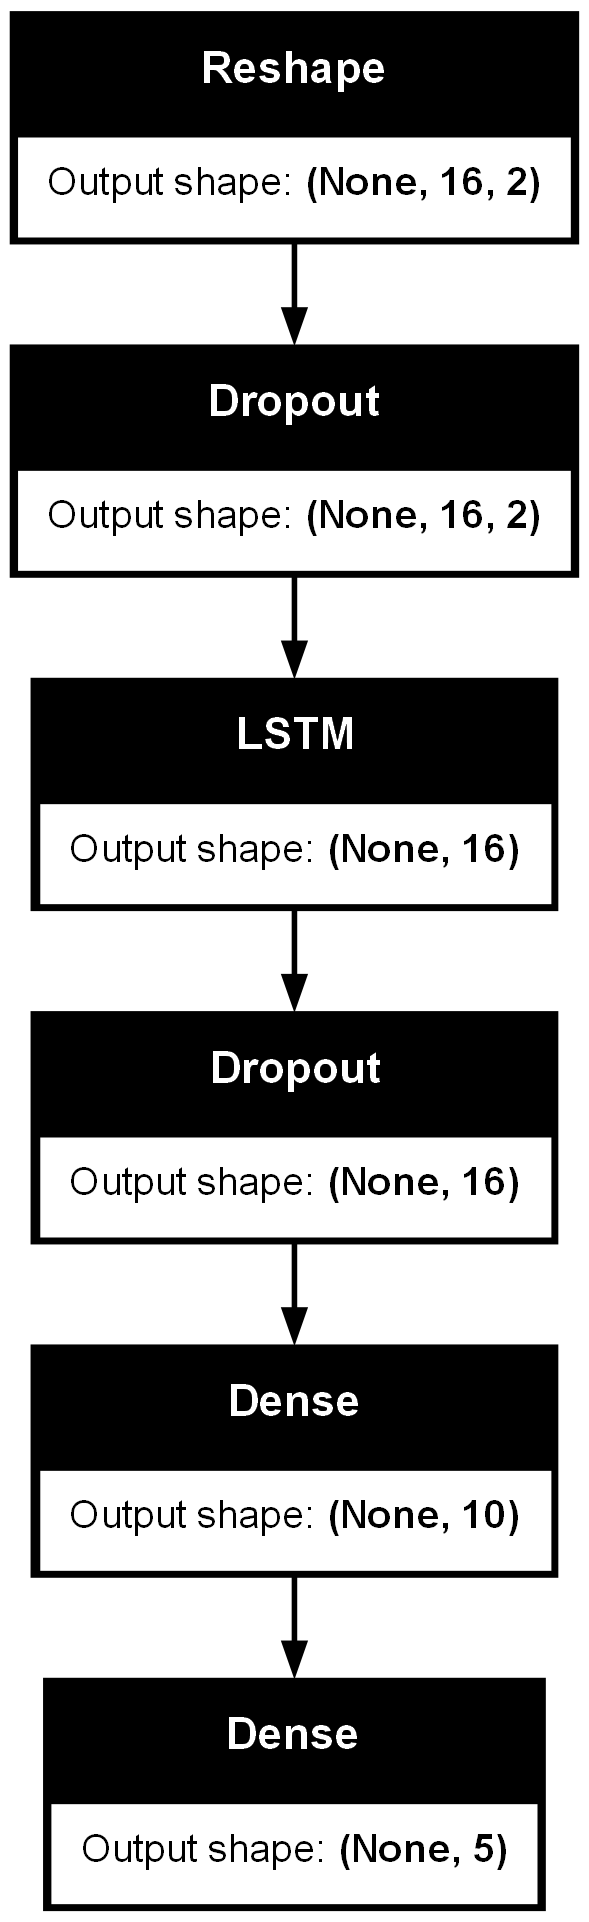

In [203]:
tf.keras.utils.plot_model(model, show_shapes=True)

## *Set up callbacks for the model*

### *Model checkpoint callback*

In [204]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

### *Model early stopping callback*

In [205]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

## *Model compilation*

In [206]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# MODEL TRAINING

In [207]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3429 - loss: 1.5892
Epoch 1: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\point_history_classifier.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3444 - loss: 1.5883 - val_accuracy: 0.3824 - val_loss: 1.5368
Epoch 2/1000
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3811 - loss: 1.4990
Epoch 2: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\point_history_classifier.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3852 - loss: 1.4936 - val_accuracy: 0.6737 - val_loss: 1.2724
Epoch 3/1000
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5893 - loss: 1.2235
Epoch 3: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\point_history_classifier.keras
49/49 ━━━━━━━━━━━

# MODEL EVALUATION

## *Evaluate validation results*

In [208]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1219 


## *Prediction test*

### *Loading a saved model*

In [209]:
model = tf.keras.models.load_model(model_save_path)

### *Prediction testing*

In [210]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


[2.0494953e-22 3.1949749e-13 8.2197034e-11 9.9999523e-01 4.7739868e-06]
3


# CONFUSION MATRIX

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


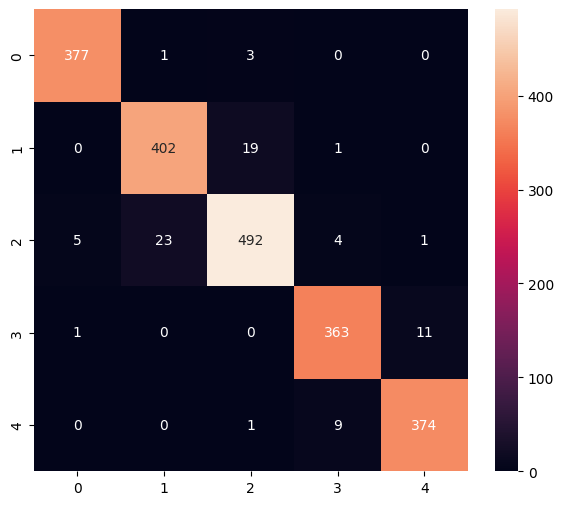

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       381
           1       0.94      0.95      0.95       422
           2       0.96      0.94      0.95       525
           3       0.96      0.97      0.97       375
           4       0.97      0.97      0.97       384

    accuracy                           0.96      2087
   macro avg       0.96      0.96      0.96      2087
weighted avg       0.96      0.96      0.96      2087



In [211]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# TRAINING HISTORY OF THE MODEL

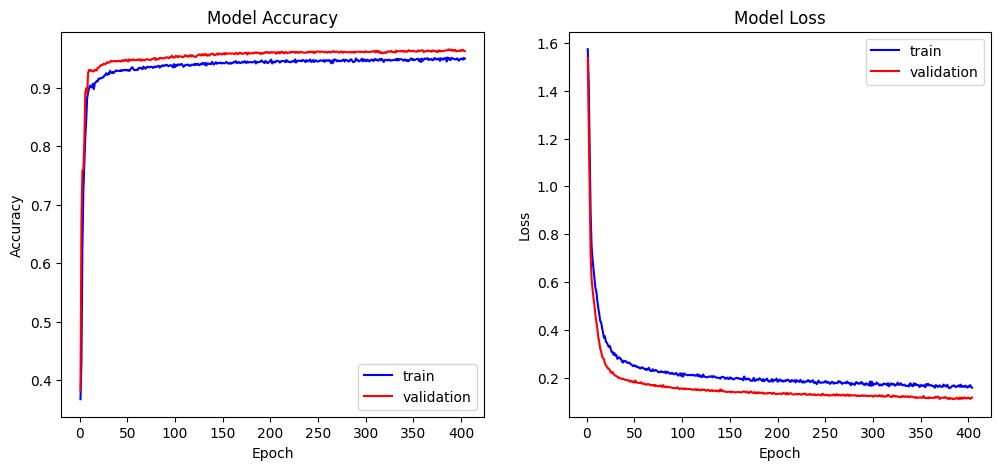

In [212]:
def plot_history(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="train")
    plt.plot(x, val_accuracy, "r", label="validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="train")
    plt.plot(x, val_loss, "r", label="validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    
plot_history(history)

# MODEL CONVERTING FOR TensorFlow-Lite

## *Model export*

In [213]:
# model.save(model_save_path, include_optimizer=False)
model.export(filepath=saved_model_path, format="tf_saved_model")

INFO:tensorflow:Assets written to: e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\assets


INFO:tensorflow:Assets written to: e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\assets


Saved artifact at 'e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer_28')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2070822244720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822249120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822245248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822243488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822240496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822243664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2070822244368: TensorSpec(shape=(), dtype=tf.resource, name=None)


## *Load the exported model*

In [214]:
model = tf.keras.models.load_model(model_save_path)

## *Transform the model (**quantize**)*

In [215]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)  
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

16640

# REASONING TEST

## *Set up an interpreter*

In [216]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

## *Get input tensor*

In [217]:
input_details = interpreter.get_input_details()

## *Get output tensor*

In [218]:
output_details = interpreter.get_output_details()

## *Set the value for the input tensor*

In [219]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

## *Inference implementation*

In [220]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 15.6 ms
Wall time: 997 µs


## *Print the results*

In [221]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2115813e-22 3.4236161e-13 8.7340350e-11 9.9999487e-01 5.1157481e-06]
3
